# Grid layout optimization

[Try this yourself](https://colab.research.google.com/github/DTUWindEnergy/TopFarm2/blob/master/docs/notebooks/regular_grid_optimization.ipynb) (requires google account)


In this example, the wind farm layout is set up to represent a grid that depends on the inter-turbine spacing of the wind farm. This creates a regular layout where the turbines do not change their individual positions. An additional cost model component is created to translate the grid layout to individual turbine positions for later used in the topfarm optimization problem.

**Install TOPFARM if needed**

In [1]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

**First we import basic Python elements and some Topfarm classes**

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from py_wake.examples.data.hornsrev1 import V80, Hornsrev1Site
from py_wake import BastankhahGaussian
from py_wake.utils.gradients import autograd

from topfarm import TopFarmProblem
from topfarm.plotting import XYPlotComp
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.utils import regular_generic_layout, regular_generic_layout_gradients

This example is using the **topfarm.reg_x_key** and **topfarm.reg_y_key** which defaults to 'sx' and 'sy' respectively to indicate turbine spacing in x- and y-directions.

The `TopfarmProblem` has to be instantiated with **'grid_layout_comp='** where you convert spacings into XY-coordinates, which enables the use of AEP-components and constraint components as `XYBoundaryConstraint` and `SpacingConstraint` components which rely on XY-coordinates. This is done by the **reg_grid_comp** component, taking the inter-turbine spacing and grid rotation as design variables.

The regular grid functions in topfarm.utils also supports grid rotation, row-staggering and number of rows to number of columns ratio, as follows:

    regular_generic_layout(n_wt, sx, sy, stagger, rotation, x0=0, y0=0, ratio=1.0):
    '''
    Parameters
    ----------
    n_wt : int
        number of wind turbines
    sx : float
        spacing (in turbine diameters or meters) between turbines in x direction
    sy : float
        spacing (in turbine diameters or meters) between turbines in y direction
    stagger : float
        stagger (in turbine diameters or meters) distance every other turbine column
    rotation : float
        rotational angle of the grid in degrees
    ratio : float
        ratio between number of columns and number of rows (1.0)

    Returns
    -------
    xy : array
        2D array of x- and y-coordinates (in turbine diameters or meters)


**First we set up site and optimization problem**

In [3]:
#specifying the site and wind turbines to use
site = Hornsrev1Site()
wt = V80()
D = wt.diameter()
windFarmModel = BastankhahGaussian(site, wt)
n_wt = 16
boundary = [[-800,-50], [1200, -50], [1200,2300], [-800, 2300]]
stagger = 1 * D   #to create a staggered layout 

def reg_func(sx, sy, rotation, **kwargs):
    x, y = regular_generic_layout(n_wt, sx, sy, stagger, rotation)
    return [x, y]

def reg_grad(sx, sy, rotation, **kwargs):
    dx_dsx, dy_dsx, dx_dsy, dy_dsy, dx_dr, dy_dr = regular_generic_layout_gradients(n_wt, sx, sy, stagger, rotation)
    return [[dx_dsx, dy_dsx], [dx_dsy, dy_dsy], [dx_dr, dy_dr]]

reg_grid_comp = CostModelComponent(input_keys=[('sx', 0), 
                                               ('sy', 0),
                                               ('rotation', 0)],
                              n_wt=n_wt,
                              cost_function=reg_func,
                              cost_gradient_function = reg_grad,
                              output_keys= [('x', np.zeros(n_wt)), ('y', np.zeros(n_wt))],
                              objective=False,
                              use_penalty=False,
                              )

def aep_fun(x, y):
    aep = windFarmModel(x, y).aep().sum()
    return aep

daep = windFarmModel.aep_gradients(gradient_method=autograd, wrt_arg=['x', 'y'])

aep_comp = CostModelComponent(input_keys=['x', 'y'],
                              n_wt=n_wt,
                              cost_function=aep_fun,
                              cost_gradient_function = daep,
                              output_keys= ("aep", 0),
                              output_unit="GWh",
                              maximize=True,
                              objective=True)

problem = TopFarmProblem(design_vars={'sx': (3*D, 2*D, 15*D), 
                                      'sy': (4*D, 2*D, 15*D), 
                                       'rotation': (50, 0, 90)
                                      },
                         constraints=[XYBoundaryConstraint(boundary),
                                      SpacingConstraint(4*D)],
                        grid_layout_comp=reg_grid_comp,
                        n_wt = n_wt,
                        cost_comp=aep_comp,
                        driver=EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=200),
                        plot_comp=XYPlotComp(),
                        expected_cost=0.1,
                        )

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


Before running the optimization we can plot the regular wind farm layout with the **reg_func**, specifying an initial value for the inter-turbine spacing of 3D and rotation of 50 $deg$. You can also change the input values of the function to see how the wind farm layout changes and distorts when given a rotational angle.

Text(0.5, 1.0, 'Staggered wind farm layout with inter-turbine spacing of 3D')

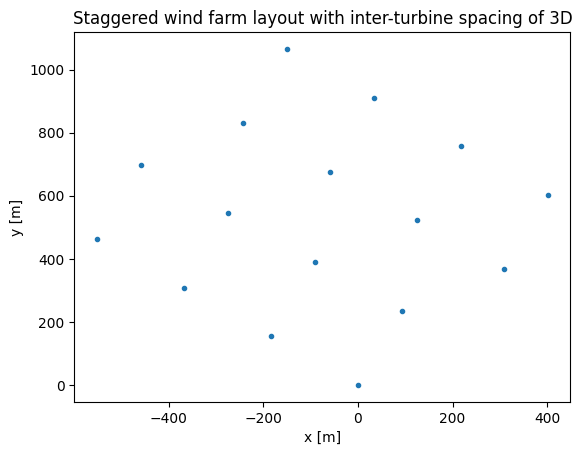

In [4]:
x, y = reg_func(3*D, 3*D, 50)
plt.figure()
plt.plot(x,y,'.')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Staggered wind farm layout with inter-turbine spacing of 3D')

**Now we run the optimization**

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1400.9892034300512
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1
Optimization Complete
-----------------------------------


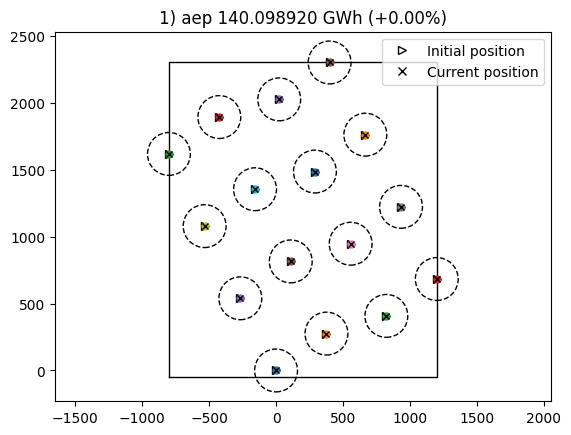

In [8]:
cost, state, recorder = problem.optimize(disp=False)

The optimization now works by using the individual x and y coordinates of the turbines to move them around the wind farm. With this modification, it is also possible to use the `XYPlotComponent` from TOPFARM, as it can only take the x and y positions as arguments instead of the inter-turbine spacings (sx and sy).

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


(-140.09892034300512,
 {'sx': array([459.46510417]),
  'sy': array([601.383788]),
  'rotation': array([26.32240851])})

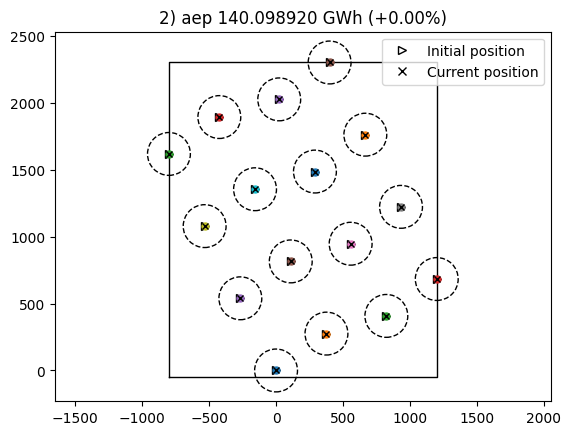

In [11]:
problem.evaluate()